In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from CourantFunctions import CourantFunctions as cf
import MathHelper as mh
import pandas as pd
import math
import time
from scipy import integrate
sns.set(rc={'figure.figsize':(25,10)})
#input data
l = 0.01
N = 512
T=75*math.pow(10,-7)
#T=12*math.pow(12,-7)
step = l/N
#gamma and beta
gamma = beta = 0.5
#густина
rho=7500#ok
#механічне напруження
sigma=0
#коефіцієнт теплового розширення
alpha=0.000002#ok
#теплові внутрішні об'ємні сили
w=0
#механічні внутрішні об'ємні сили
f=0
#модуль Юнга
c=139000000000#ok
#коефіцієнт п'єзоелектрики
E=15.1#ok
e=0
#електрична індукція
D=0
#коефіцієнт діелектричної проникливості
g=0.00000000646#ok
#задане значення теплового потоку в точці L
def hShtrih(t):#ok
    return 0
#коефіцієнт теплопровідності
Lambda=1.1#ok
#коефіцієнт піроелектрики
pSmall=0.00027#ok 
#почтакове значення тепла T
Tzero = 1/298
#коефіцієнт електропровідності
z = 5*math.pow(10,-12)#ok
#питома теплоємності
cE = 350#ok
#коеф вязкості
a = 4#ok

def sigmaShtrih(t):#ok
    if t<=5*math.pow(10,-7):
        return 5*math.pow(10,6)
    else:
        return 0

def JShtrih(t):#ok
    #if t<=5*math.pow(10,-7):
     #   return 100
    #else:
    return 0

In [2]:
#ФУНКЦІЇ куранта
fi = []
fiDerivatives = []
xi = [0]
for i in range(1,N+1):
    xi.append(xi[i-1]+step)

for i in range(0,N+1):
    new_function = cf(i,N,l)
    fi.append(new_function.fi)
    fiDerivatives.append(new_function.fiDerivative)
    
print(f"{len(fi)},{len(fiDerivatives)}")

513,513


In [3]:
#формування початкових матриць
def FillFiAndDerMatrix(koeficient):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*fi[0](x)*fiDerivatives[1](x)),xi[0],xi[1])#так само
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fiDerivatives[i-1](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*fi[N](x)*fiDerivatives[N-1](x)),xi[N-1],xi[N])#міняю індекси в фі і фі дер
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
            
    return np.array(CMatrixNew)
    
def FillMMatrix(koeficient):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[0](x)*fi[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*fi[0](x)*fi[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*fi[i-1](x)*fi[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fi[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fi[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fi[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*fi[N-1](x)*fi[N](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[N](x)*fi[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
        
    return np.array(CMatrixNew)
###
def FillAMatrix(koeficient):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[0](x)*fiDerivatives[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i-1](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[N-1](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
        
    return np.array(CMatrixNew)
###
def FillEMatrix(koeficient):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[0](x)*fiDerivatives[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i-1](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[N-1](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
    ###-1 multiplication
    ResMatrix = list((-1)*np.array(CMatrixNew))
        
    return np.array(ResMatrix)
###
def FillSMatrix(koeficient,pytoma,start_temp):#rho = 7500, cE = 350, Tzero = 293
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[0](x)*fi[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[0](x)*fi[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[i-1](x)*fi[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[i](x)*fi[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[i](x)*fi[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[i](x)*fi[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[N-1](x)*fi[N](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[N](x)*fi[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
        
    return np.array(CMatrixNew)
###
def FillYMatrix(c,alpha):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (c*alpha*fi[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (c*alpha*fi[0](x)*fiDerivatives[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (c*alpha*fi[i](x)*fiDerivatives[i-1](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (c*alpha*fi[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (c*alpha*fi[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (c*alpha*fi[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (c*alpha*fi[N](x)*fiDerivatives[N-1](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (c*alpha*fi[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
        
    return np.array(CMatrixNew)
###
def FillPMatrix(p):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (p*fi[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (p*fi[1](x)*fiDerivatives[0](x)),xi[0],xi[1])#так само
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (p*fi[i](x)*fiDerivatives[i-1](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (p*fi[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (p*fi[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (p*fi[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (p*fi[N-1](x)*fiDerivatives[N](x)),xi[N-1],xi[N])#міняю індекси в фі і фі дер
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (p*fi[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
            
    ###-1 multiplication
    ResMatrix = list((-1)*np.array(CMatrixNew))
        
    return np.array(ResMatrix)
###
def FillKMatrix(koeficient,start_temp):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[0](x)*fiDerivatives[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[i-1](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[N-1](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
        
    return np.array(CMatrixNew)

In [4]:
start_time = time.time()
MMatrix = FillMMatrix(rho)
AMatrix = FillAMatrix(a)
EMatrix = FillEMatrix(E)
ZMatrix = FillAMatrix(z)
SMatrix = FillMMatrix(rho*cE*Tzero)
CMatrix = FillAMatrix(c)
YMatrix = FillFiAndDerMatrix(c*alpha)
GMatrix = FillAMatrix(g)
PMatrix = (-1)*FillFiAndDerMatrix(pSmall)
KMatrix = FillKMatrix(Lambda,Tzero)

In [5]:
#формування векторів початкових умов правої частини слар
u0 = np.zeros((N+1))
udot0 = np.zeros((N+1))
p0 = np.zeros((N+1))
thetta0 = np.zeros((N+1))  

In [6]:
Nt = 4000
dt=T/Nt
t = 0
#constructing main matrix
MainMatrix = list(np.zeros((3*(N+1),3*(N+1))))
for i in range(0,N+1):
    for j in range(0,N+1):
        #first row
        MainMatrix[i][j] = MMatrix[i][j] + (dt*gamma)*AMatrix[i][j] + 0.5*dt*dt*beta*CMatrix[i][j]
        MainMatrix[i][j+N+1] = (-1)*dt*gamma*EMatrix.transpose()[i][j]
        MainMatrix[i][j+2*(N+1)] = (-1)*dt*gamma*YMatrix.transpose()[i][j]
        #second row
        MainMatrix[i+N+1][j] = dt*gamma*EMatrix[i][j]
        MainMatrix[i+N+1][j+N+1] = GMatrix[i][j]+(dt*gamma*ZMatrix[i][j])
        MainMatrix[i+N+1][j+2*(N+1)] = PMatrix.transpose()[i][j]
        #third row
        MainMatrix[i+2*(N+1)][j] = dt*gamma*YMatrix[i][j]
        MainMatrix[i+2*(N+1)][j+N+1] = PMatrix[i][j]
        MainMatrix[i+2*(N+1)][j+2*(N+1)] = (SMatrix[i][j]+(dt*gamma)*KMatrix[i][j])#ok
        

MainMatrix[0][0] = pow(10,20)
MainMatrix[N+1][N+1] = pow(10,20)
MainMatrix[2*N+2][2*N+2] = pow(10,20)
#print(pd.DataFrame(MainMatrix))

In [7]:
#розвязок однокрокової рекурентної схеми
t_lim = T
LJplusHalf = np.zeros((N+1))
RJplusHalf = np.zeros((N+1))
FJplusHalf = np.zeros((N+1))
result = np.zeros(3*(N+1))
thettaP_energy = np.zeros((Nt+1))
potential_energy = np.zeros((Nt+1))
kinetic_energy = np.zeros((Nt+1))
electric_energy = np.zeros((Nt+1))
heat_energy = np.zeros((Nt+1))
mech_loss = np.zeros((Nt+1))
electric_loss = np.zeros((Nt+1))
heat_loss = np.zeros((Nt+1))
right_part = np.zeros((Nt+1))
time_iter_count = 0
while t<=T:
    #формуємо вектори L, R та F за лінійними функціоналами
    for i in range(0,N+1):
        LJplusHalf[i] = sigmaShtrih(t)*fi[i](l)
        RJplusHalf[i] = JShtrih(t)*fi[i](l)
        FJplusHalf[i] = (-hShtrih(t)*fi[i](l))*Tzero
    if time_iter_count<=Nt-1:
        right_part[time_iter_count+1]=right_part[time_iter_count]
        mech_loss[time_iter_count+1]=mech_loss[time_iter_count]
        electric_loss[time_iter_count+1]=electric_loss[time_iter_count]
        heat_loss[time_iter_count+1]=heat_loss[time_iter_count]
    #енергія
    for i in range(0,N):
        #потенційна
        potential_energy[time_iter_count]+=0.5*mh.IntegrateGauss(lambda x:(c*
        (u0[i]**2*fiDerivatives[i](x)**2
        +2*u0[i]*fiDerivatives[i](x)*u0[i+1]*fiDerivatives[i+1](x)
        +u0[i+1]**2*fiDerivatives[i+1](x)**2)),
        xi[i],
        xi[i+1]
        )
        #кінетична
        kinetic_energy[time_iter_count]+=0.5*mh.IntegrateGauss(lambda x:(rho*
        (udot0[i]**2*fi[i](x)**2
        +2*udot0[i]*fi[i](x)*udot0[i+1]*fi[i+1](x)
        +udot0[i+1]**2*fi[i+1](x)**2)),
        xi[i],
        xi[i+1]
        )
        #електрична
        electric_energy[time_iter_count]+=0.5*mh.IntegrateGauss(lambda x:(g*
        (p0[i]**2*fiDerivatives[i](x)**2
        +2*p0[i]*fiDerivatives[i](x)*p0[i+1]*fiDerivatives[i+1](x)
        +p0[i+1]**2*fiDerivatives[i+1](x)**2)),
        xi[i],
        xi[i+1]
        )
        #теплова
        heat_energy[time_iter_count]+=0.5*mh.IntegrateGauss(lambda x:(rho*cE*Tzero*
        (thetta0[i]**2*fi[i](x)**2
        +2*thetta0[i]*fi[i](x)*thetta0[i+1]*fi[i+1](x)
        +thetta0[i+1]**2*fi[i+1](x)**2)),
        xi[i],
        xi[i+1]
        )
        #невідомий доданок
        thettaP_energy[time_iter_count]+=0.5*mh.IntegrateGauss(lambda x:((-1)*pSmall*
        (thetta0[i]**2*fi[i](x)**2
        +2*thetta0[i]*fi[i](x)*p0[i+1]*fiDerivatives[i+1](x)
        +p0[i+1]**2*fiDerivatives[i+1](x)**2)),
        xi[i],
        xi[i+1]
        )
        #втрати
        if time_iter_count<=Nt-1:
            #механічні
            mech_loss[time_iter_count+1]+=mh.Integrate2D(lambda x,t:(a*
            (udot0[i]**2*fiDerivatives[i](x)**2
            +2*udot0[i]*fiDerivatives[i](x)*udot0[i+1]*fiDerivatives[i+1](x)
            +udot0[i+1]**2*fiDerivatives[i+1](x)**2)),
            xi[i],xi[i+1],time_iter_count * dt, (time_iter_count + 1) * dt)
            #електричні
            electric_loss[time_iter_count+1]+=mh.Integrate2D(lambda x,t:(z*
            (p0[i]**2*fiDerivatives[i](x)**2
            +2*p0[i]*fiDerivatives[i](x)*p0[i+1]*fiDerivatives[i+1](x)
            +p0[i+1]**2*fiDerivatives[i+1](x)**2)),
            xi[i],xi[i+1],time_iter_count * dt, (time_iter_count + 1) * dt)
            #теплові
            heat_loss[time_iter_count+1]+=mh.Integrate2D(lambda x,t:(Lambda*Tzero*
            (thetta0[i]**2*fiDerivatives[i](x)**2
            +2*thetta0[i]*fiDerivatives[i](x)*thetta0[i+1]*fiDerivatives[i+1](x)
            +thetta0[i+1]**2*fiDerivatives[i+1](x)**2)),
            xi[i],xi[i+1],time_iter_count * dt, (time_iter_count + 1) * dt)
            
    if time_iter_count<=Nt-1:
        #права частина
        right_part[time_iter_count+1]+=mh.IntegrateGauss(lambda t:(sigmaShtrih(t)*udot0[N]),time_iter_count*dt,(time_iter_count+1)*dt)
    
    #формуємо праву частину слар
    Vec1 = LJplusHalf - AMatrix.dot(udot0) - CMatrix.dot(u0) - dt*gamma*CMatrix.dot(udot0)+EMatrix.transpose().dot(p0)+YMatrix.transpose().dot(thetta0)
    Vec2 = RJplusHalf - EMatrix.dot(udot0)-ZMatrix.dot(p0)
    Vec3 = FJplusHalf - KMatrix.dot(thetta0)-YMatrix.dot(udot0)
    rightSideVec = list(Vec1) + list(Vec2) + list(Vec3)
    #розвязуємо слар
    result = np.linalg.solve(np.array(MainMatrix), np.array(rightSideVec))
    #відокремлюємо окремі розв'язки з загального
    uKoefsSub = np.zeros((N+1))
    pKoefsSub = np.zeros((N+1))
    thettaKoefsSub = np.zeros((N+1))
    for i in range(0,N+1):
        uKoefsSub[i] = result[i]
        pKoefsSub[i] = result[N+1+i]
        thettaKoefsSub[i] = result[2*N+2+i]
    u0Next = u0 + dt*udot0 + 0.5*dt*dt*np.array(uKoefsSub)
    p0Next = p0 + dt*np.array(pKoefsSub)
    udot0Next = udot0 + dt*np.array(uKoefsSub)
    thetta0Next = thetta0 + dt*np.array(thettaKoefsSub)
    #оновлюємо значення векторів
    u0 = u0Next
    p0 = p0Next
    udot0 = udot0Next
    thetta0 = thetta0Next
    
    
    if t>t_lim:
        break
        
    t+=dt
    time_iter_count+=1
    
end_time = time.time()

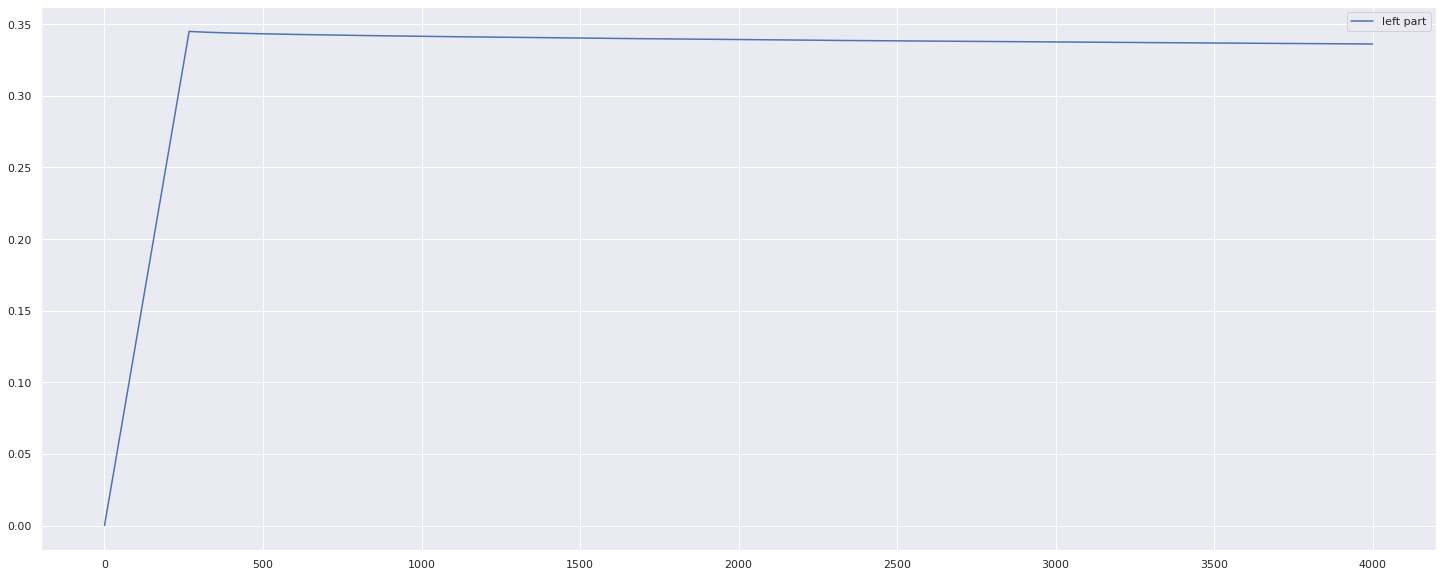

In [8]:
left_part_eq = np.array(potential_energy)+np.array(kinetic_energy)+np.array(electric_energy)+np.array(heat_energy)
+np.array(mech_loss)+np.array(electric_loss)+np.array(heat_loss)#+np.array(thettaP_energy)
plt.plot(left_part_eq, label = "left part")
plt.legend()
plt.show()

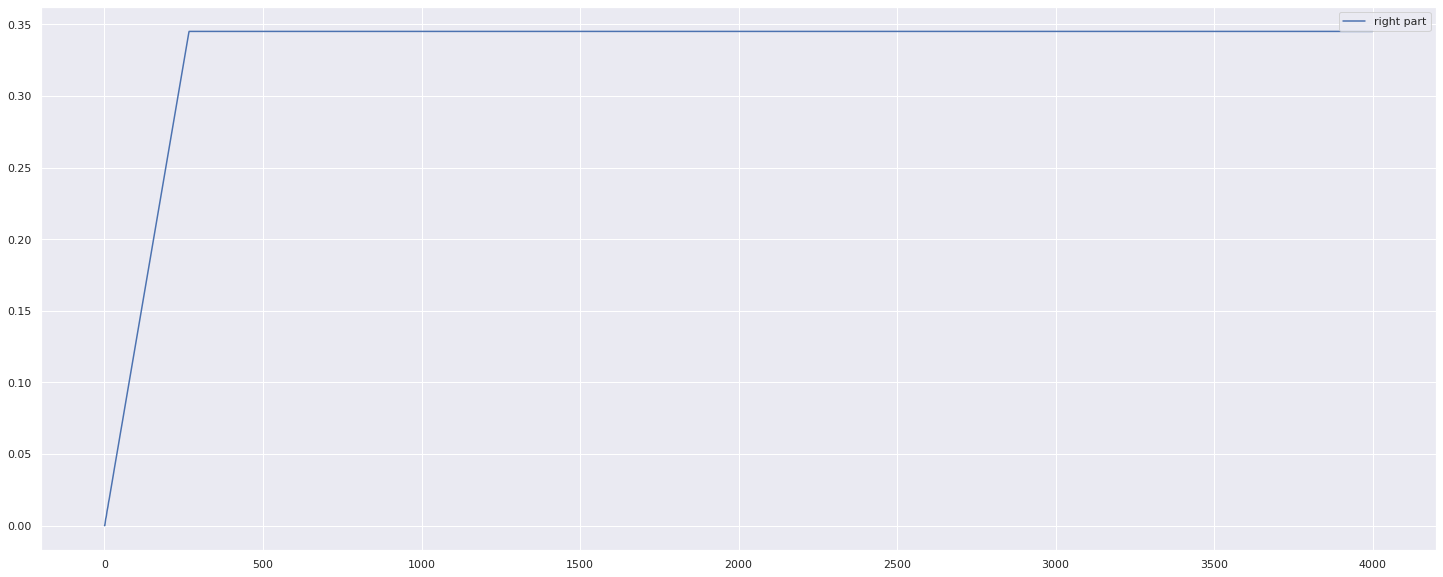

In [9]:
plt.plot(right_part, label = "right part")
plt.legend()
plt.show()

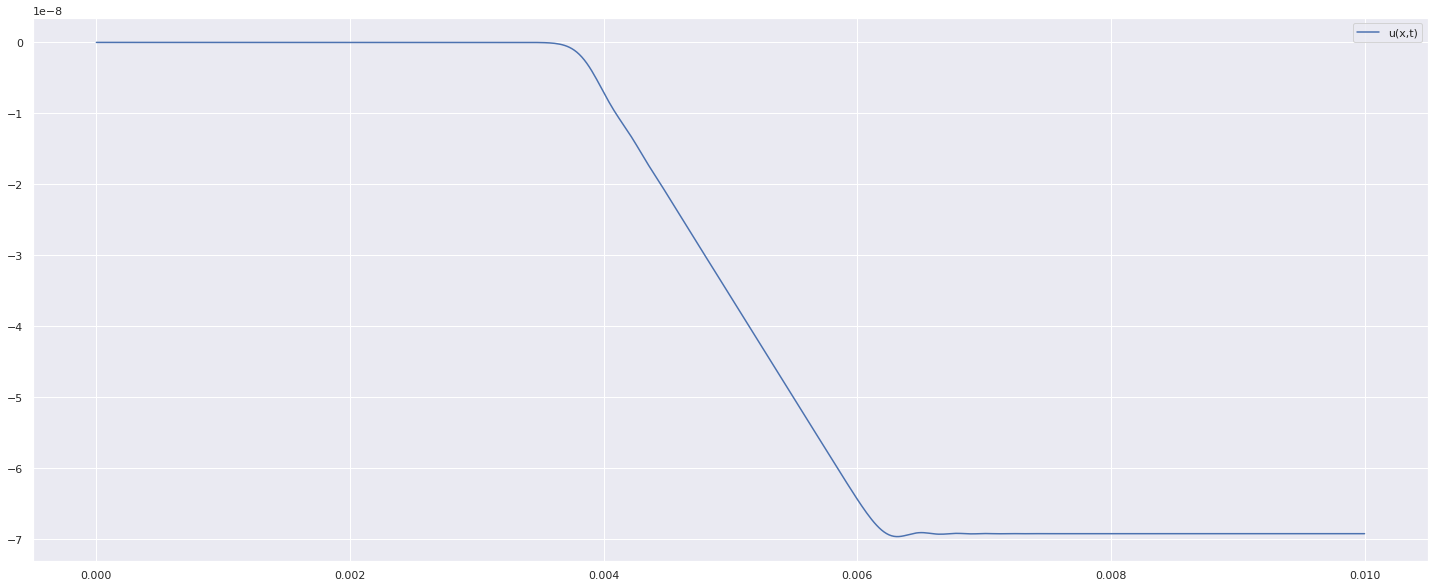

In [10]:
plt.plot(xi,u0,label = 'u(x,t)')
plt.legend()
plt.show()

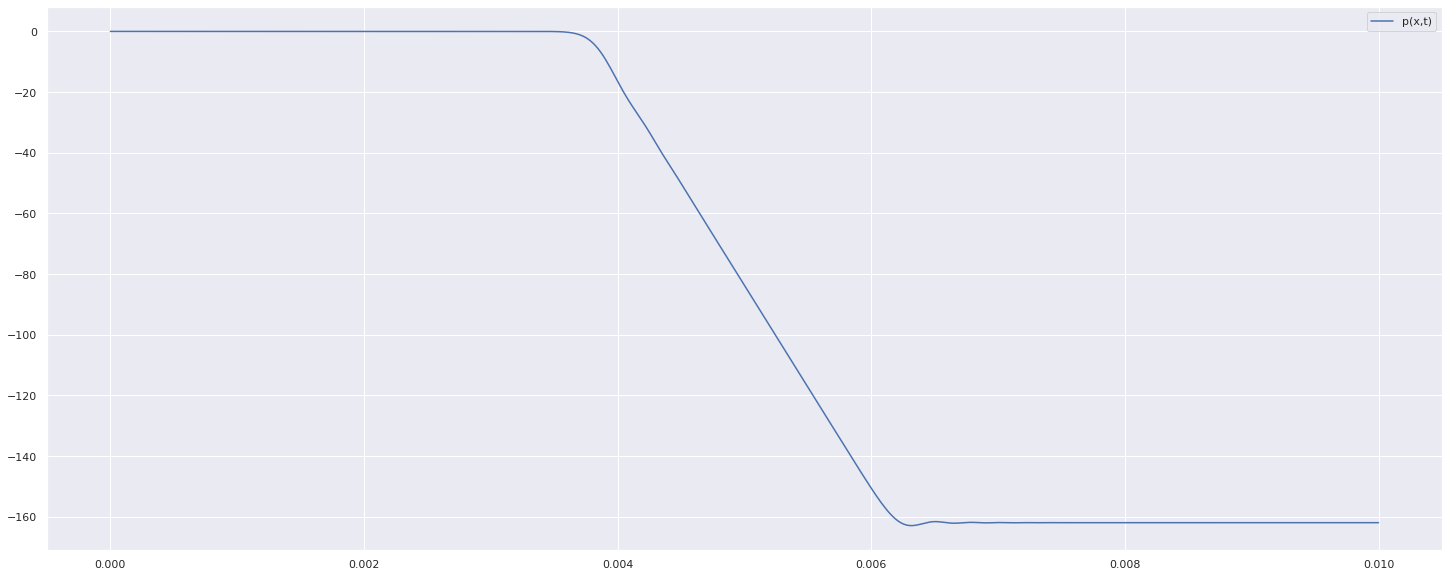

In [11]:
plt.plot(xi,p0,label = 'p(x,t)')
plt.legend()
plt.show()

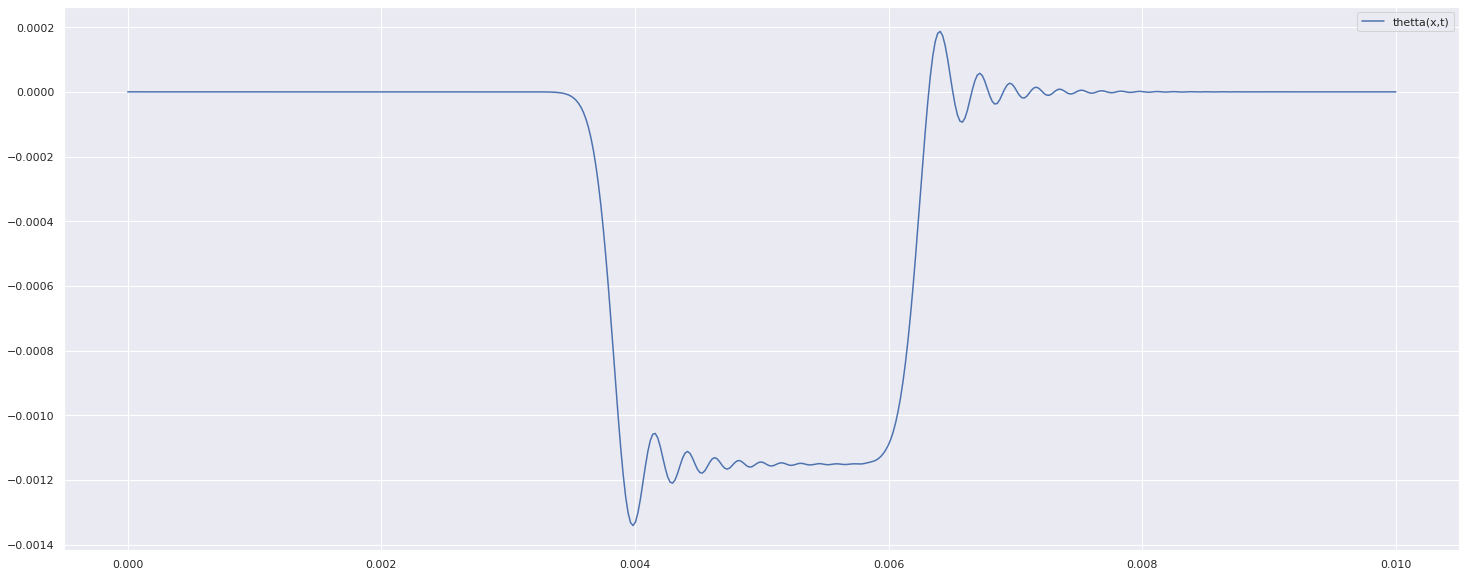

In [12]:
plt.plot(xi,thetta0,label = 'thetta(x,t)')
plt.legend()
plt.show()

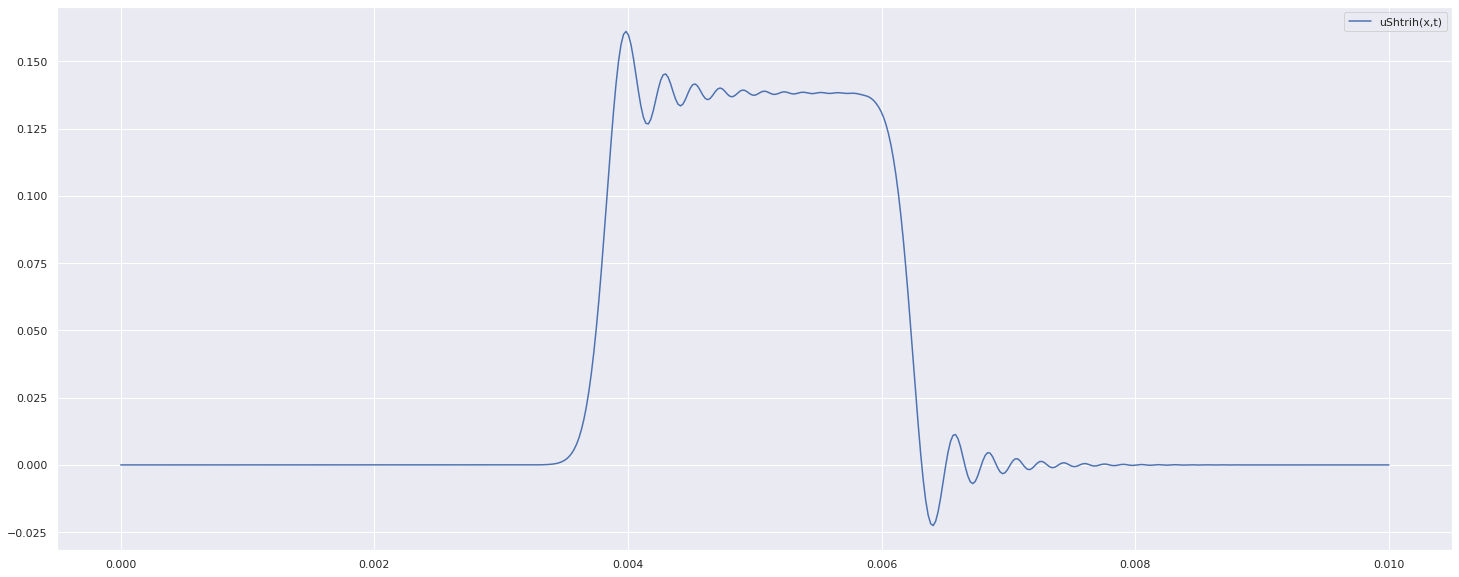

In [13]:
plt.plot(xi,udot0,label = 'uShtrih(x,t)')
plt.legend()
plt.show()

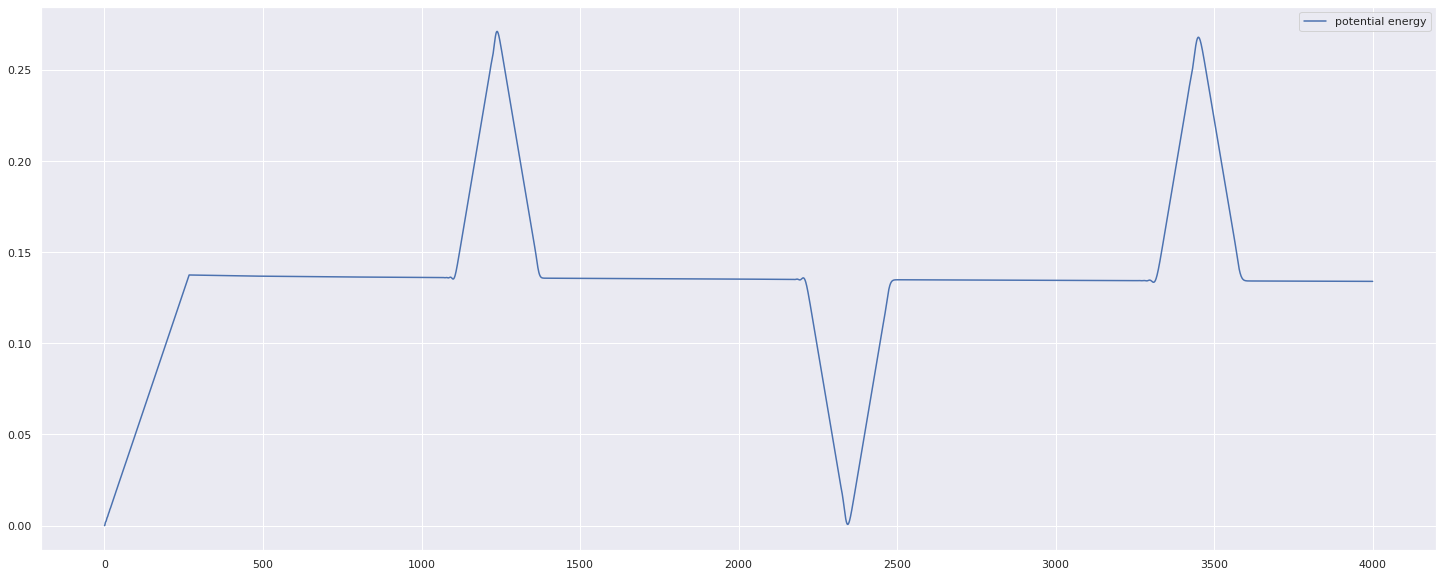

In [14]:
plt.plot(potential_energy,label = 'potential energy') 
plt.legend()
plt.show()

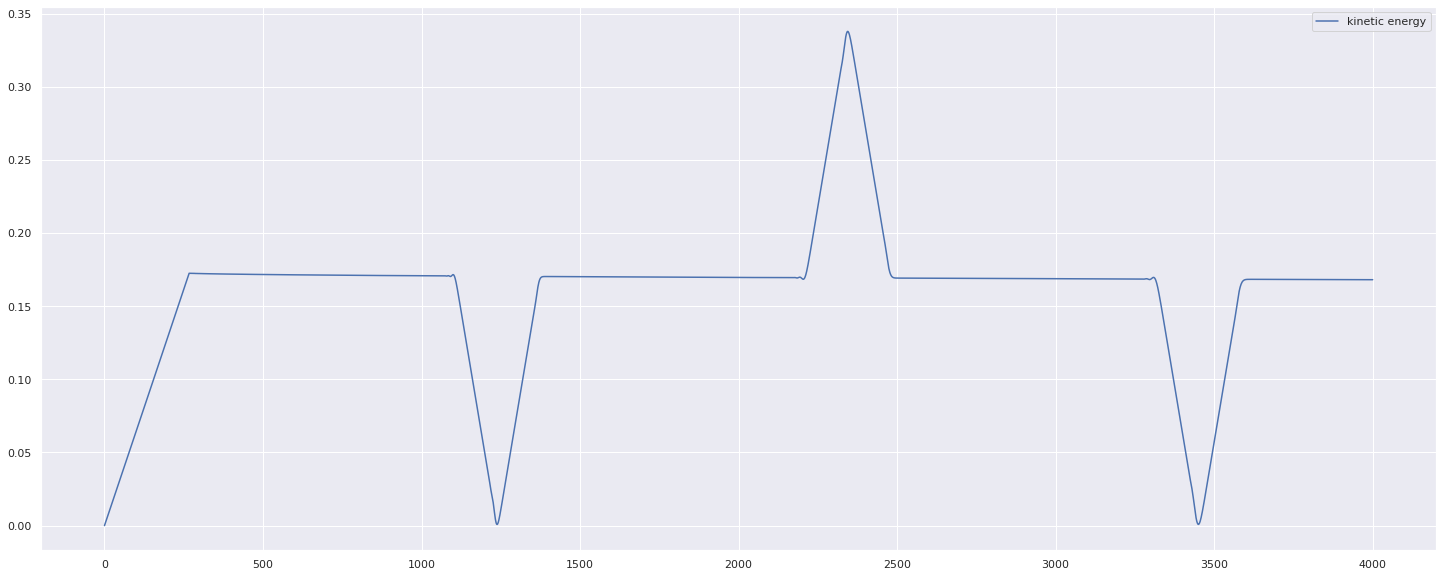

In [15]:
plt.plot(kinetic_energy,label = 'kinetic energy') 
plt.legend()
plt.show()

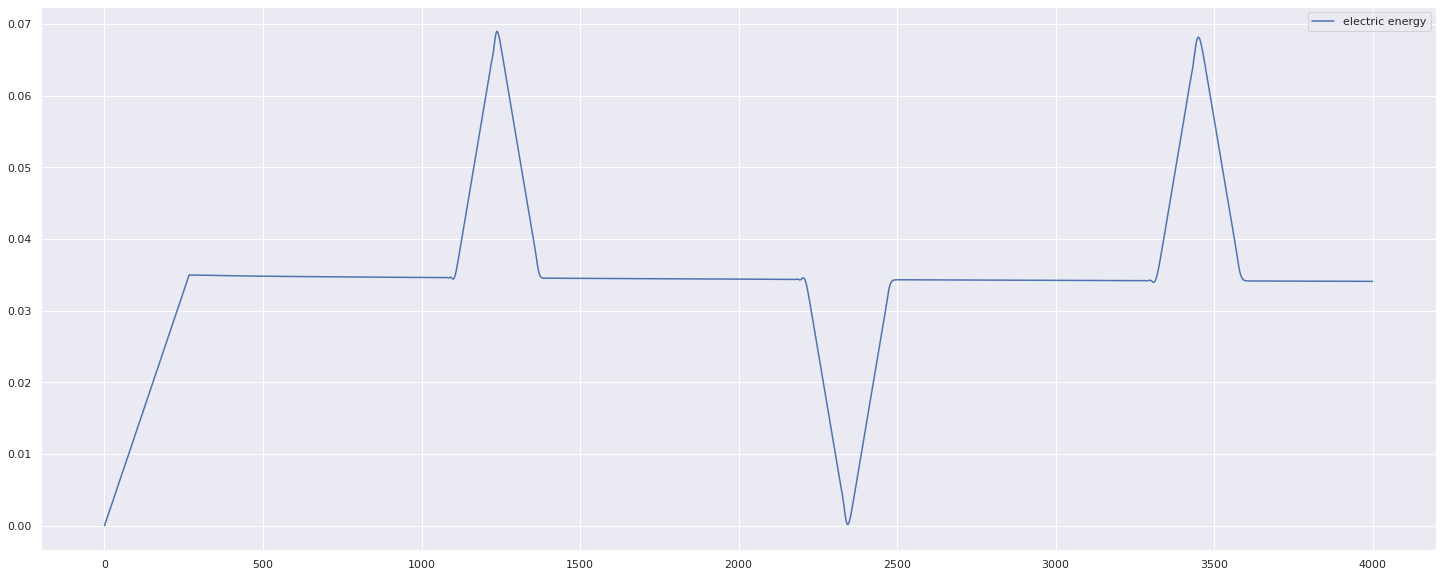

In [16]:
plt.plot(electric_energy,label = 'electric energy') 
plt.legend()
plt.show()

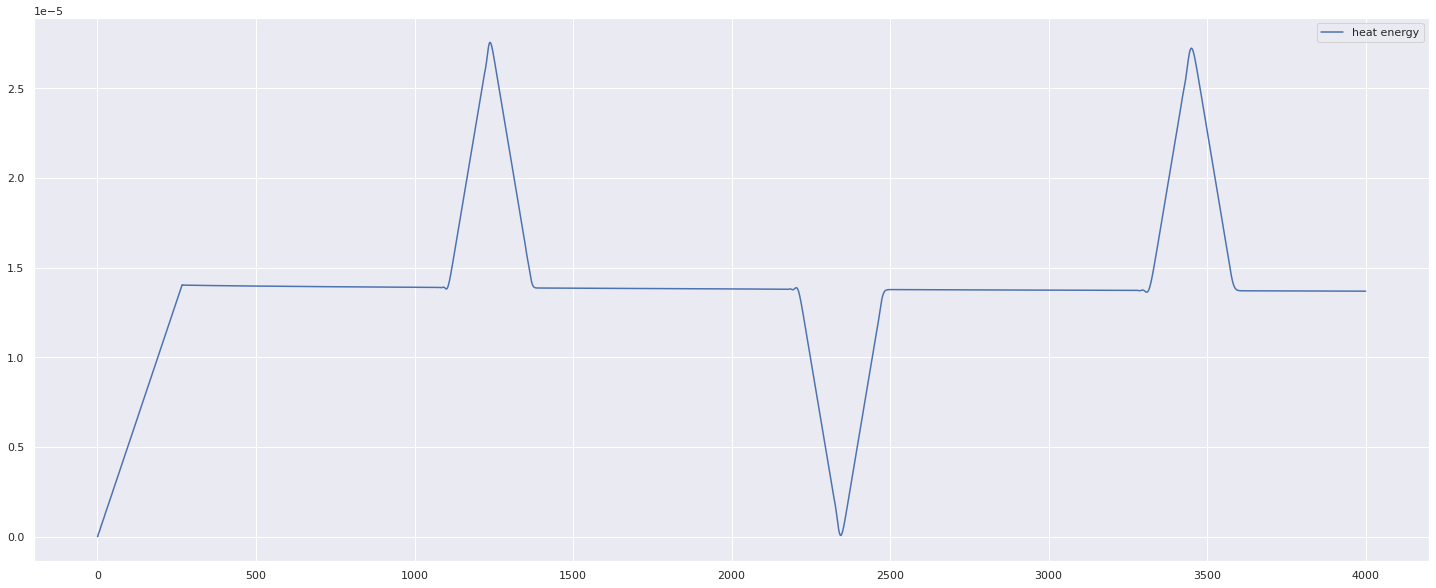

In [17]:
plt.plot(heat_energy,label = 'heat energy') 
plt.legend()
plt.show()

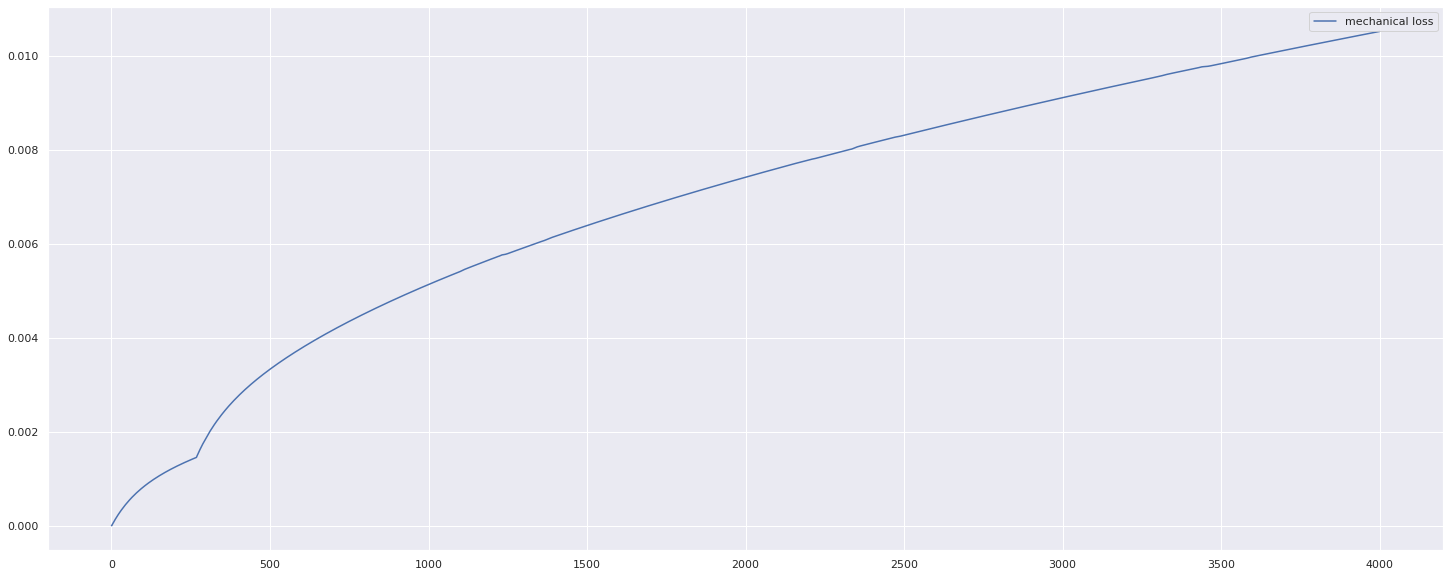

In [18]:
plt.plot(mech_loss,label = 'mechanical loss') 
plt.legend()
plt.show()

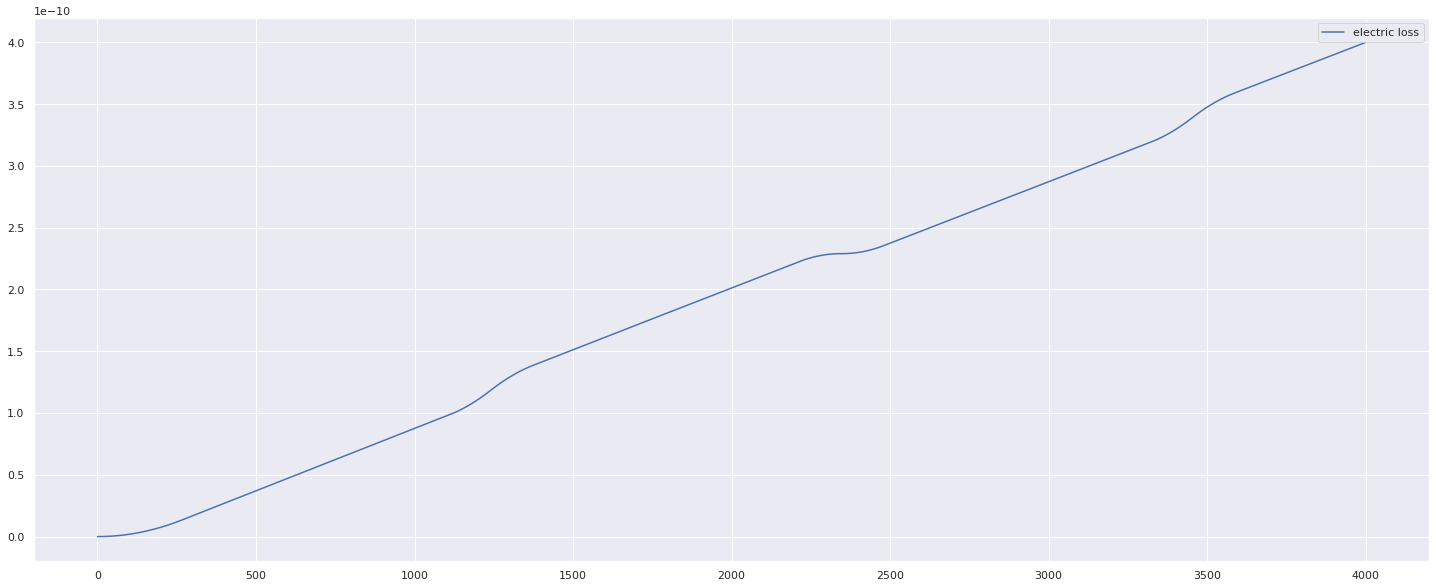

In [19]:
plt.plot(electric_loss,label = 'electric loss') 
plt.legend()
plt.show()

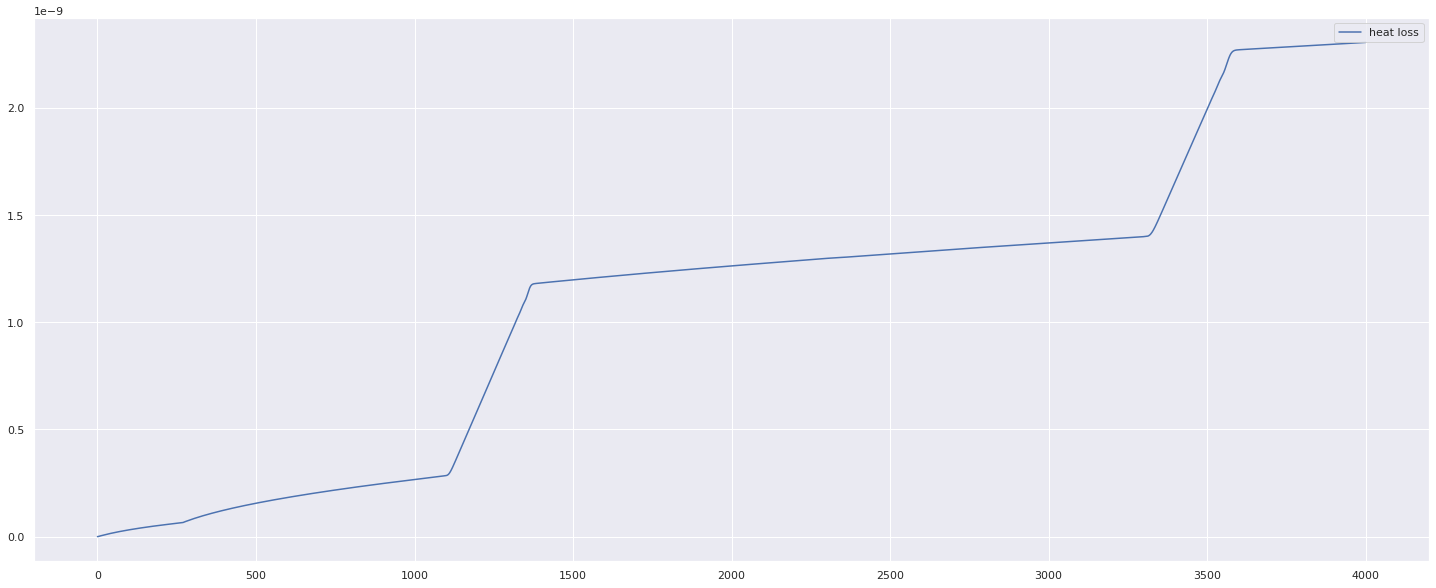

In [20]:
plt.plot(heat_loss,label = 'heat loss') 
plt.legend()
plt.show()

In [21]:
#norm calculation
L2_Norm_u = 0
L2_Norm_p = 0
L2_Norm_thetta = 0
for i in range(0,N):
    L2_Norm_u+=mh.IntegrateGauss(lambda x:((u0[i]*fi[i](x)+u0[i+1]*fi[i+1](x))*(u0[i]*fi[i](x)+u0[i+1]*fi[i+1](x))),xi[i],xi[i+1])
    L2_Norm_p+=mh.IntegrateGauss(lambda x:((p0[i]*fi[i](x)+p0[i+1]*fi[i+1](x))*(p0[i]*fi[i](x)+p0[i+1]*fi[i+1](x))),xi[i],xi[i+1])
    L2_Norm_thetta+=mh.IntegrateGauss(lambda x:((thetta0[i]*fi[i](x)+thetta0[i+1]*fi[i+1](x))*(thetta0[i]*fi[i](x)+thetta0[i+1]*fi[i+1](x))),xi[i],xi[i+1])

L2_Norm_u = math.sqrt(L2_Norm_u)
L2_Norm_p = math.sqrt(L2_Norm_p)
L2_Norm_thetta = math.sqrt(L2_Norm_thetta)
print(f"L2 Norm for u with N = {N} elements = {L2_Norm_u}")
print("-----------------------------------------------------------------")
print(f"L2 Norm for p with N = {N} elements = {L2_Norm_p}")
print("-----------------------------------------------------------------")
print(f"L2 Norm for thetta with N = {N} elements = {L2_Norm_thetta}")
print("-----------------------------------------------------------------")

L2 Norm for u with N = 512 elements = 4.7141928118653785e-09
-----------------------------------------------------------------
L2 Norm for p with N = 512 elements = 11.027151809687096
-----------------------------------------------------------------
L2 Norm for thetta with N = 512 elements = 5.573366863059968e-05
-----------------------------------------------------------------


In [22]:
time_elapsed = end_time - start_time
print(f"Time elapsed for L = {l}, N = {N}, T = {T}, Nt = {Nt}: {time_elapsed}")

Time elapsed for L = 0.01, N = 512, T = 7.499999999999999e-06, Nt = 4000: 1195.6970331668854
